<a href="https://colab.research.google.com/github/chominyeong/Tobigs20/blob/main/6WEEK/NN%20Advanced/NN_Adv_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NN Adv Assignment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Tobigs20_week6_NNAdv/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Tobigs20_week6_NNAdv/Test.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train['label'].nunique()

10

In [ ]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = train.iloc[:, 1:].values    #label 제외 전부
y = train.iloc[:, 0].values     #label

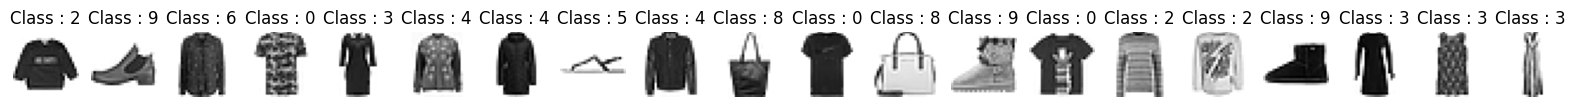

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')    #28x28 = 784
  plt.title(f'Class : {y[idx]}')

In [ ]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

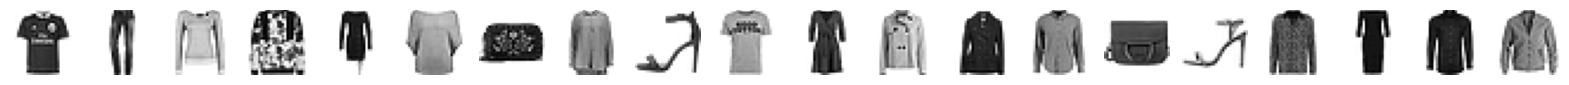

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)   #2D Tensor(행렬)로 만들기 28x28 → 1x784
y_train = torch.LongTensor(y_train)    #1D Tensor(벡터)로 만들기

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')       #만약 GPU를 사용 가능하다면 device 값이 cuda가 되고,
else:
  DEVICE = torch.device('cpu')        #아니라면 cpu가 된다.

print(DEVICE)

cpu


In [ ]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [ ]:
from torch.utils.data import Dataset          #Dataset은 샘플과 정답(label)을 저장하고,
from torch.utils.data import DataLoader       #DataLoader는 Dataset을 순회 가능한 객체(iterable)로 감싼다.

class DataSet(Dataset):
  # 생성자, 데이터를 전처리 하는 부분
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  # 데이터셋의 총 길이 반환
  def __len__(self):
    return len(self._image)

  # idx(인덱스)에 해당하는 입출력 데이터를 반환
  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label    #이미지와 라벨 출력

In [ ]:
#DataLoader는 Dataset을 batch기반의 딥러닝모델 학습을 위해서 미니배치 형태로 만들어 학습할 때 이용할 수 있게 형태를 만들어준다.

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [ ]:
for X, y in train_loader:
    print(f"Shape of X : {X.shape}")
    print(f"Shape of y : {y.shape} {y.dtype}")
    break

Shape of X : torch.Size([128, 784])
Shape of y : torch.Size([128]) torch.int64


In [ ]:
#학습
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

#평가
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

#예측
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

nn.Linear : 파이토치에서 사용되는 선형 변환(linear transform)을 수행하는 클래스

nn.Linear(in_features, out_features, bias)
- in_features : 입력 텐서의 크기. 입력 텐서의 차원(dimension) 또는 특성(feature)의 수.
- out_features : 출력 텐서의 크기. 출력 텐서의 차원(dimension) 또는 특성(feature)의 수.
- bias : 평향을 사용할지 여부를 지정. 기본값은 True

In [ ]:
class MyNet(nn.Module):
    def __init__(self) -> None:
          super(MyNet, self).__init__()
          self.layers = nn.Sequential(
              nn.Linear(784, 512),
              torch.nn.BatchNorm1d(512),
              nn.ReLU(),
              nn.Linear(512, 128),
              torch.nn.BatchNorm1d(128),
              nn.ReLU(),
              nn.Linear(128, 10)
          )


    def forward(self, x):
        # nn.Sequential로 정의한 레이어들의 순전파 동작이 자동으로 수행됨
        x = self.layers(x)
        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.7120, 	Train Accuracy: 80.33 %, 	Val Loss: 0.5082, 	Val Accuracy: 83.78 % 

[EPOCH: 2], 	Train Loss: 0.4218, 	Train Accuracy: 86.65 %, 	Val Loss: 0.4003, 	Val Accuracy: 86.91 % 

[EPOCH: 3], 	Train Loss: 0.3516, 	Train Accuracy: 88.15 %, 	Val Loss: 0.3534, 	Val Accuracy: 87.91 % 

[EPOCH: 4], 	Train Loss: 0.3087, 	Train Accuracy: 89.37 %, 	Val Loss: 0.3315, 	Val Accuracy: 88.08 % 

[EPOCH: 5], 	Train Loss: 0.2777, 	Train Accuracy: 90.39 %, 	Val Loss: 0.3222, 	Val Accuracy: 88.37 % 

[EPOCH: 6], 	Train Loss: 0.2525, 	Train Accuracy: 91.32 %, 	Val Loss: 0.3258, 	Val Accuracy: 88.01 % 

[EPOCH: 7], 	Train Loss: 0.2324, 	Train Accuracy: 91.89 %, 	Val Loss: 0.3229, 	Val Accuracy: 88.38 % 

[EPOCH: 8], 	Train Loss: 0.2117, 	Train Accuracy: 92.76 %, 	Val Loss: 0.3273, 	Val Accuracy: 88.38 % 

[EPOCH: 9], 	Train Loss: 0.1937, 	Train Accuracy: 93.40 %, 	Val Loss: 0.3238, 	Val Accuracy: 87.92 % 

[EPOCH: 10], 	Train Loss: 0.1777, 	Train Accuracy: 93.97 %, 	Val Loss: 0.

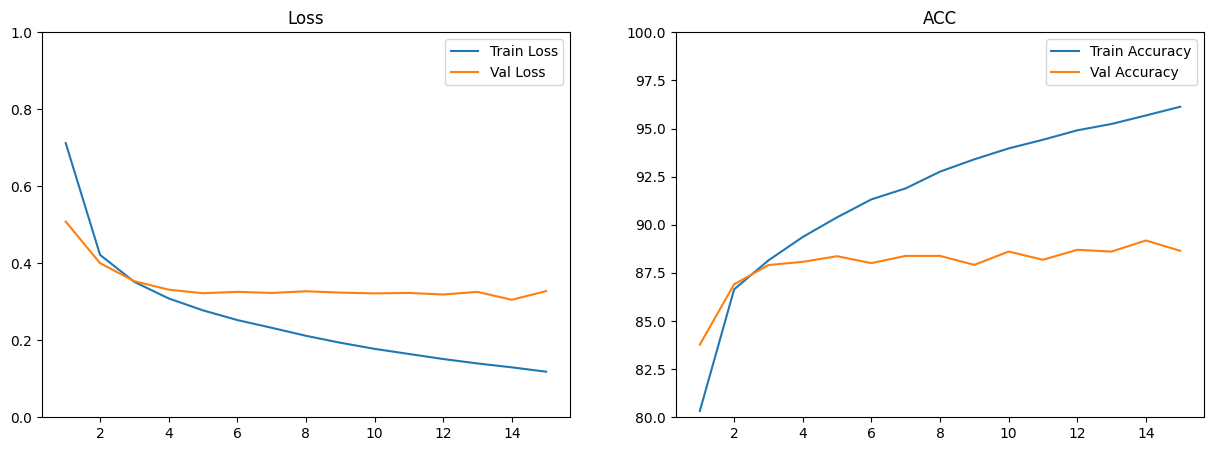

In [ ]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [ ]:
'''
시도 1.
# def __init__(self) -> None:
#         super(MyNet, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(784, 512),
#             nn.ReLU(),
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Linear(128, 10)
#         )

- Optimizer : Adam(lr = 0.001)
- Regularization : x
- Initialization : ReLU
- Normalization : x

선형 변환 후 활성화 함수인 ReLU를 이용해 비선형 변환만 시켰을 때의 최고 성능은 92.69% 이다.

[EPOCH: 15], 	Train Loss: 0.1943, 	Train Accuracy: 92.69 %, 	Val Loss: 0.3094, 	Val Accuracy: 89.10 %

'''

In [ ]:
'''
시도 2.
# def __init__(self) -> None:
#         super(MyNet, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(784, 512),
#             torch.nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Linear(512, 128),
#             torch.nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Linear(128, 10)
#         )

- Optimizer : Adam(lr = 0.001)
- Regularization : x
- Initialization : ReLU
- Normalization : Batch Nomalization

batch 정규화를 추가로 시켰을 때 성능이 높아진 것을 확인할 수 있다. batch 정규화의 자체적 regularization에 의해 dropout은 추가하지 않았다.
layer, instance, group normalization도 실행했으나 성능이 높지 않았다.

[EPOCH: 15], 	Train Loss: 0.1165, 	Train Accuracy: 95.73 %, 	Val Loss: 0.3625, 	Val Accuracy: 88.45 %

'''

In [ ]:
'''
시도 3.
    # def __init__(self) -> None:
    #     super(MyNet, self).__init__()
    #     self.layers = nn.Sequential(
    #         nn.Linear(784, 512),
    #         torch.nn.BatchNorm1d(512),
    #         nn.Tanh(),
    #         nn.Linear(512, 128),
    #         torch.nn.BatchNorm1d(128),
    #         nn.Tanh(),
    #         nn.Linear(128, 10)
    #     )

- Optimizer : Adam(lr = 0.001)
- Regularization : x
- Initialization : Tanh
- Normalization : batch normalization

[EPOCH: 15], 	Train Loss: 0.1410, 	Train Accuracy: 94.79 %, 	Val Loss: 0.4050, 	Val Accuracy: 86.41 %

'''

In [ ]:
'''
시도 4.
    # def __init__(self) -> None:
    #     super(MyNet, self).__init__()
    #     self.layers = nn.Sequential(
    #         nn.Linear(784, 512),
    #         nn.ReLU(),
    #         nn.Dropout(0.2),
    #         nn.Linear(512, 64),
    #         nn.ReLU(),
    #         nn.Linear(64, 10)
    #     )

- Optimizer : Adam(lr = 0.001)
- Regularization : Dropout(0.2)
- Initialization : ReLU
- Normalization : x

[EPOCH: 15], 	Train Loss: 0.2383, 	Train Accuracy: 91.08 %, 	Val Loss: 0.3025, 	Val Accuracy: 89.31 %

'''

In [ ]:
'''
시도 5.
    # def __init__(self) -> None:
    #     super(MyNet, self).__init__()
    #     self.layers = nn.Sequential(
    #         nn.Linear(784, 512),
    #         torch.nn.BatchNorm1d(512),
    #         nn.ReLU(),
    #         nn.Dropout(0.2),

    #         nn.Linear(512, 128),
    #         torch.nn.BatchNorm1d(128),
    #         nn.ReLU(),
    #         nn.Linear(128, 10)
    #     )

- Optimizer : Adam(lr = 0.001)
- Regularization : Dropout(0.2)
- Initialization : ReLU
- Normalization : batch normalization

[EPOCH: 15], 	Train Loss: 0.1668, 	Train Accuracy: 93.86 %, 	Val Loss: 0.2988, 	Val Accuracy: 89.64 %

'''

In [ ]:
'''
최종
# def __init__(self) -> None:
#         super(MyNet, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(784, 512),
#             torch.nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Linear(512, 128),
#             torch.nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Linear(128, 10)
#         )

- Optimizer : Adam(lr = 0.0001)
- Regularization : x
- Initialization : ReLU
- Normalization : Batch Nomalization


[EPOCH: 15], 	Train Loss: 0.1184, 	Train Accuracy: 96.13 %, 	Val Loss: 0.3277, 	Val Accuracy: 88.65 %

최종적으로 Adam optimizer의 학습률을 0.0001로, 정규화 대신 batch normalization으로 역할을 대신 하고, He-initialization을 사용한 NN이 가장 높은 accuracy(96.13 %)를 냈다.

'''